# Forecasting energy prices

Simplified from [github.com/ritikdhame/Electricity_Demand_and_Price_forecasting/](https://github.com/ritikdhame/Electricity_Demand_and_Price_forecasting/blob/main/Electricity_Demand_and_Price_forecasting.ipynb)


count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

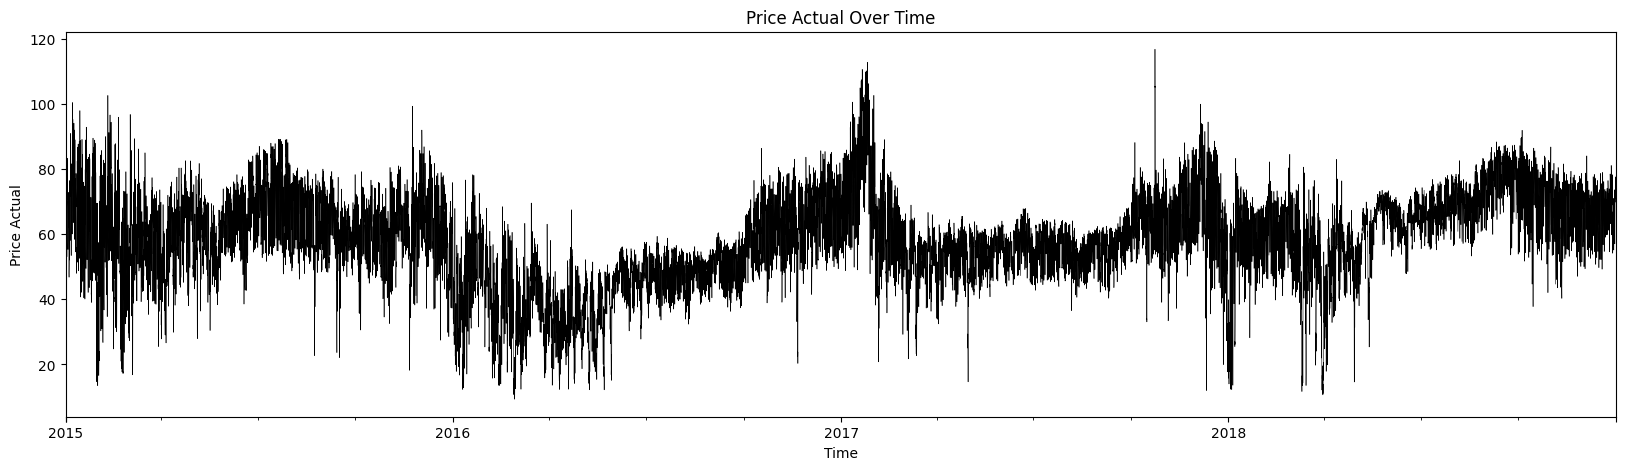

In [46]:
import pandas as pd
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/ritikdhame/Electricity_Demand_and_Price_forecasting/main/data/energy_dataset.csv"


df_energy = pd.read_csv(url)
# set time to index
df_energy["time"] = pd.to_datetime(df_energy["time"], utc=True)
df_energy = df_energy.set_index("time")


fig, ax = plt.subplots(1, 1, figsize=(20, 5))
df_energy["price actual"].plot(ax=ax, lw=0.4, color="k")
ax.set(
    title="Price Actual Over Time",
    xlabel="Time",
    ylabel="Price Actual",
)
fig.savefig("price_actual_over_time.png", dpi=300, bbox_inches="tight")

df_energy.describe().T

In [15]:
# A boat load of imports
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import (
    Input,
    LSTM,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten,
    Conv1D,
    Bidirectional,
)

In [47]:
# some helper functions


# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):

    print("Number of Nans in each column :")

    print(df_input.isnull().sum())
    print()
    print(f"Number of duplicates in the dataframe : {df_input.duplicated().sum()}")
    return


# Plot the feature correlation matrix
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15, 12))
    # plot heat map
    g = sns.heatmap(corr, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title("Feature Correlation")

    return plt.show()


# Function to transform data to ts format
def windowing(X_input, y_input, history_size):

    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])

    return np.array(data), np.array(labels).reshape(-1, 1)

## Data preprocessing


In [48]:
# use a subset of rows
df_energy = df_energy.iloc[0:3000, :]

# columns to be removed due to all 0 or Nan values
col_names = [
    "generation fossil coal-derived gas",
    "generation fossil oil shale",
    "generation fossil peat",
    "generation geothermal",
    "generation hydro pumped storage aggregated",
    "generation marine",
    "generation wind offshore",
    "forecast wind offshore eday ahead",
    "forecast solar day ahead",
    "forecast wind onshore day ahead",
]
df_energy = df_energy.drop(col_names, axis=1, errors="ignore")

# interpolate missing values
df_energy.interpolate(method="linear", limit_direction="forward", inplace=True)

# combine two features:
df_energy["generation fossil total"] = (
    df_energy["generation fossil hard coal"]
    + df_energy["generation fossil brown coal/lignite"]
)
df_energy.drop(
    ["generation fossil hard coal", "generation fossil brown coal/lignite"],
    axis=1,
    inplace=True,
)
# drop the forecast column
df_energy.drop(["total load forecast"], axis=1, inplace=True)

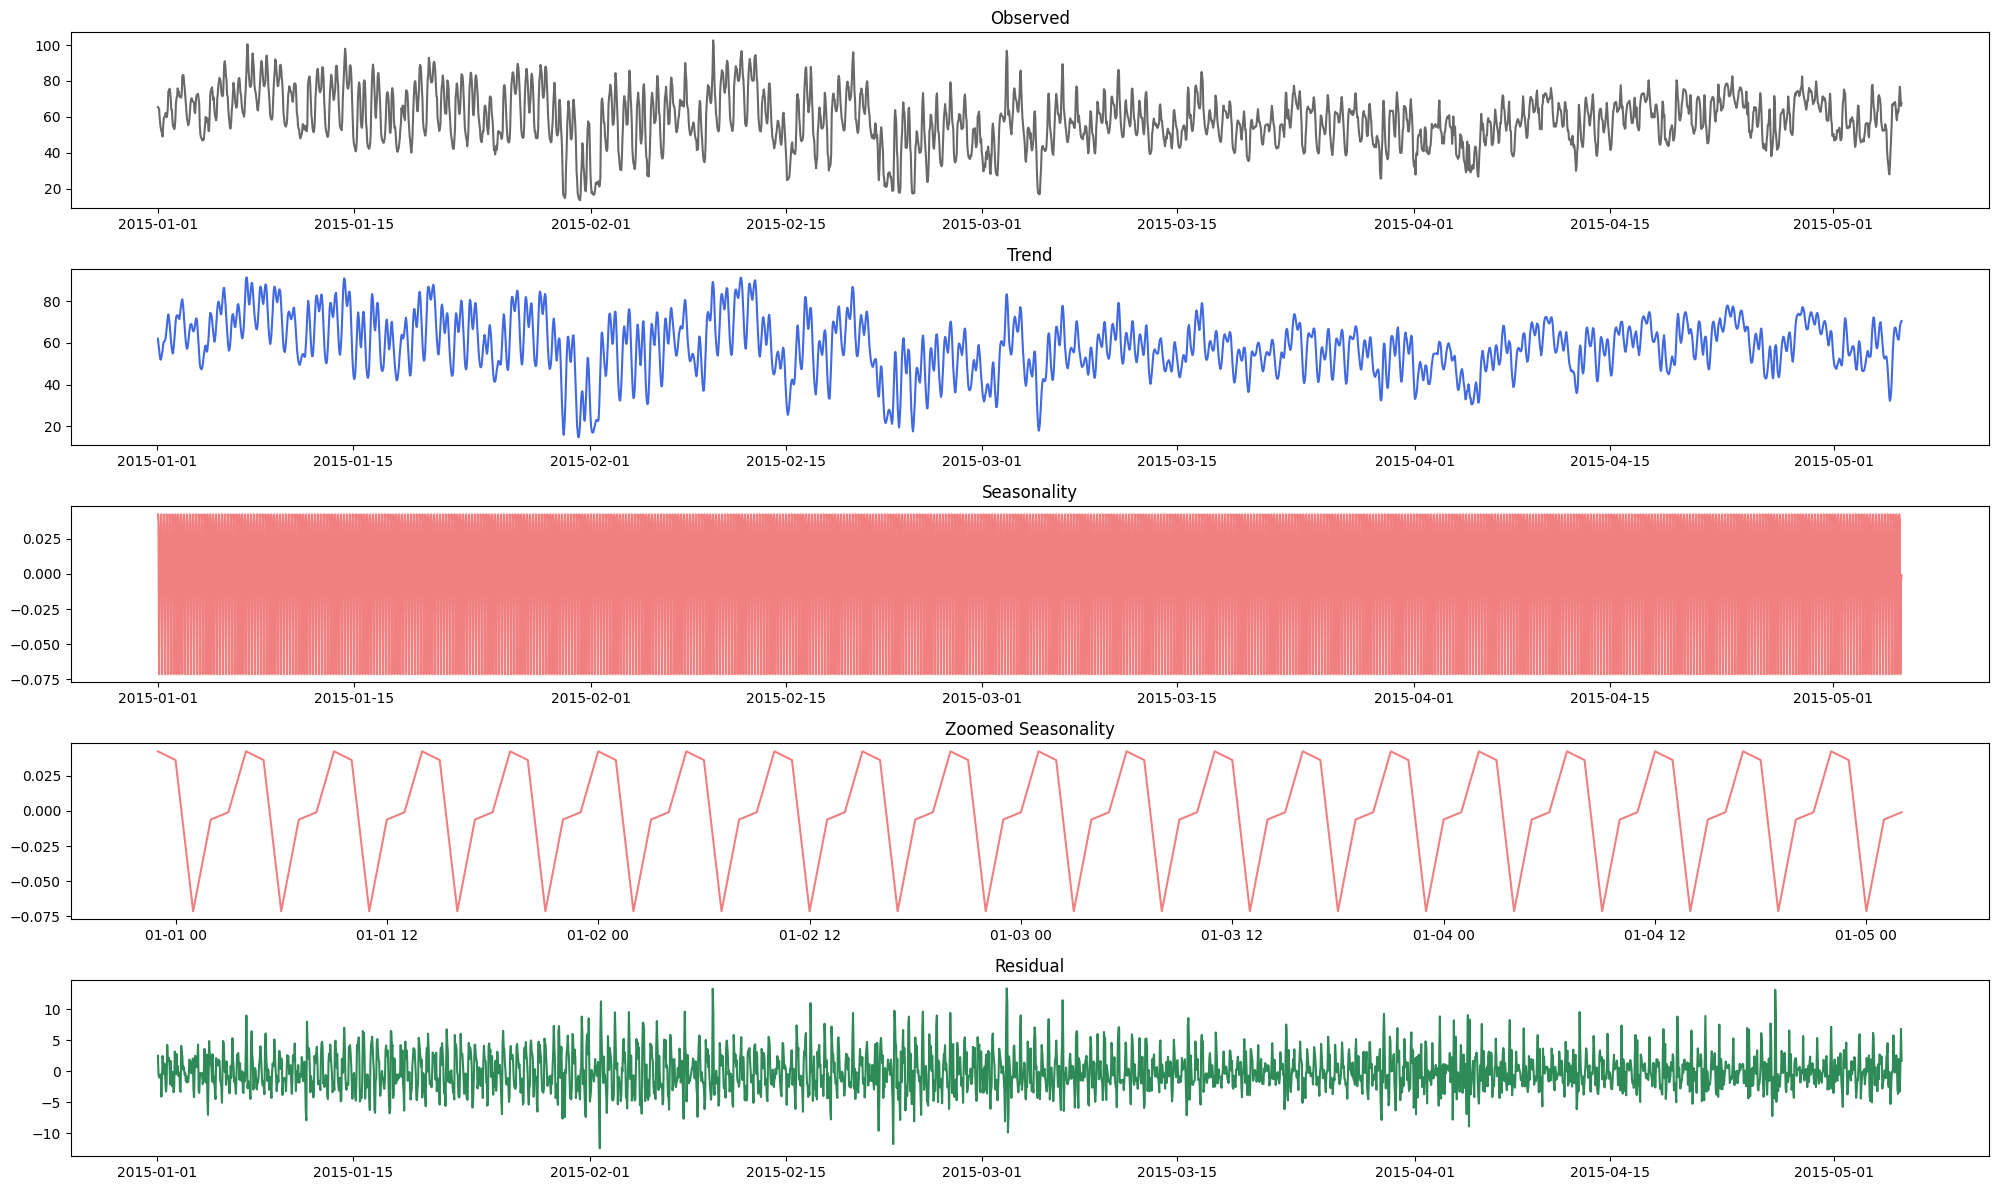

In [49]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_energy[["price actual"]].copy()

decompose_result = seasonal_decompose(decom_data, period=5, model="additive")

observed = decompose_result.observed
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color="dimgrey")
axes[0].set_title("Observed")
axes[1].plot(trend, color="royalblue")
axes[1].set_title("Trend")
axes[2].plot(seasonal, color="lightcoral")
axes[2].set_title("Seasonality")
axes[3].plot(seasonal[:100], color="lightcoral")
axes[3].set_title("Zoomed Seasonality")
axes[4].plot(residual, color="seagreen")
axes[4].set_title("Residual")

fig.tight_layout()
plt.show()

## Train-test split


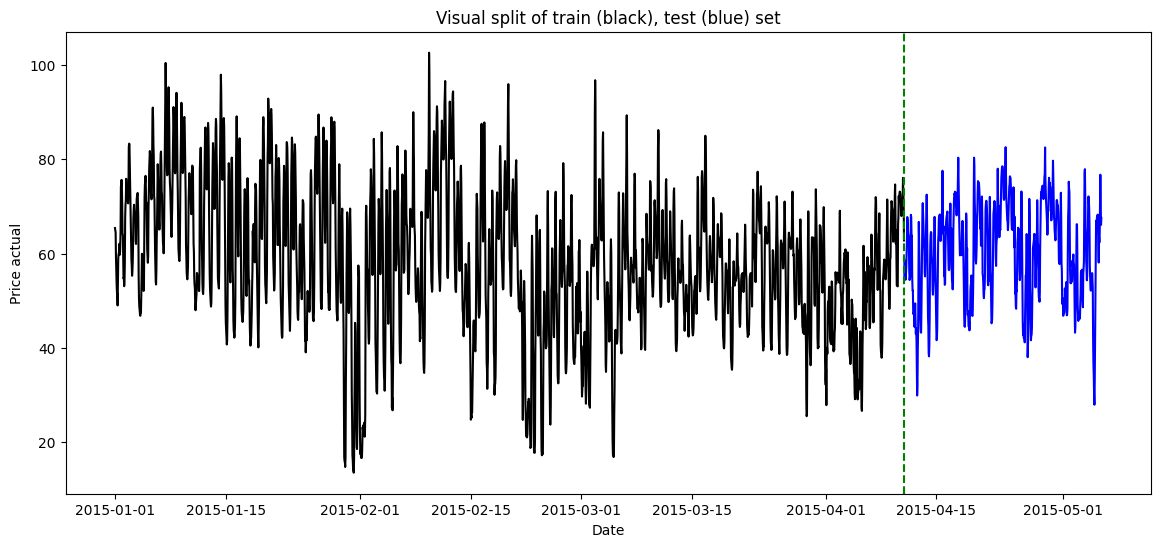

In [50]:
def get_train_test(hist_size=24):
    """
    hist_size: int, size of the history window
    """

    X = df_energy.drop(["price actual"], axis=1)
    y = df_energy[["price actual"]]

    # training set size

    train_cutoff = int(len(X) * 0.8)

    # scale the data

    scaler_y = MinMaxScaler()
    scaler_y.fit(y[:train_cutoff])
    y_norm = scaler_y.transform(y)

    scaler_X = MinMaxScaler()
    scaler_X.fit(X[:train_cutoff])
    X_norm = scaler_X.transform(X)

    # create the windowed data

    data_norm = np.concatenate((X_norm, y_norm), axis=1)
    X_train, y_train = windowing(
        data_norm[:train_cutoff, :-1], data_norm[:train_cutoff, -1], hist_size
    )

    X_test, y_test = windowing(
        data_norm[train_cutoff:, :-1], data_norm[train_cutoff:, -1], hist_size
    )
    return X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X


X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test()


fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(df_energy["price actual"].iloc[:train_cutoff], color="black")
axes.plot(df_energy["price actual"].iloc[train_cutoff:], color="blue")
axes.axvline(x=df_energy.index[train_cutoff], color="green", linestyle="--")
axes.set_title("Visual split of train (black), test (blue) set")
axes.set_xlabel("Date")
axes.set_ylabel("Price actual")
plt.show()

## Seasonal Decomposition forecast

- Univariate forecast
- Trend is extrapolated


Text(0.5, 1.0, 'MAE of the forecast: 4.74')

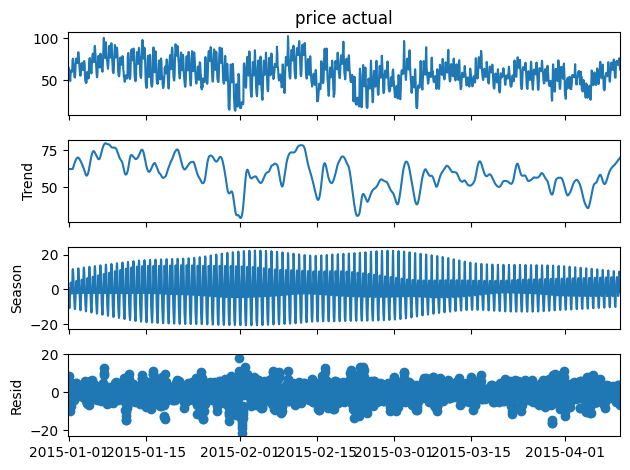

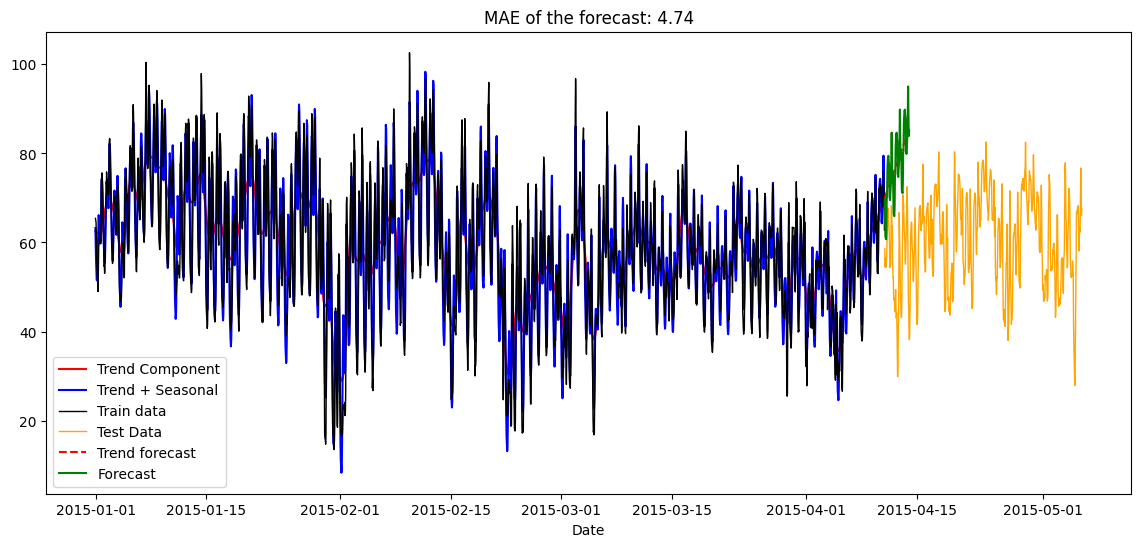

In [51]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

df_energy.index.freq = "h"
y_train = df_energy["price actual"].iloc[:train_cutoff]
y_test = df_energy["price actual"].iloc[train_cutoff:]


# Apply STL decomposition
seasonality = 25
stl = STL(y_train, seasonal=seasonality)
result = stl.fit()

# Plot the decomposition
result.plot()


# Forecast the trend using Holt's linear trend method
trend_model = ExponentialSmoothing(result.trend.dropna(), trend="add", seasonal=None)
trend_fit = trend_model.fit()

# number of seasons to forecast
n_seasons = 3

# forecast the trend component
trend_forecast = trend_fit.forecast(n_seasons * seasonality)

# Repeat the last seasonal cycle
seasonal_forecast = np.tile(result.seasonal[-seasonality:].values, n_seasons)

# Combine trend and seasonal forecasts
forecast = trend_forecast + seasonal_forecast

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(result.trend, c="r", label="Trend Component")
ax.plot(result.seasonal + result.trend, color="b", label="Trend + Seasonal")
ax.plot(y_train, label="Train data", c="k", lw=1)
ax.plot(y_test, label="Test Data", c="orange", lw=1)
ax.plot(trend_forecast, label="Trend forecast", color="r", linestyle="--")
ax.plot(trend_forecast.index, forecast, label="Forecast", color="green")
ax.set_xlabel("Date")
ax.legend()

rmse = np.sqrt(mean_absolute_error(y_test[: seasonality * n_seasons], forecast))
ax.set_title(f"MAE of the forecast: {rmse:.2f}")

### SARIMA forecast

- Univariate
- Optimize order parameters


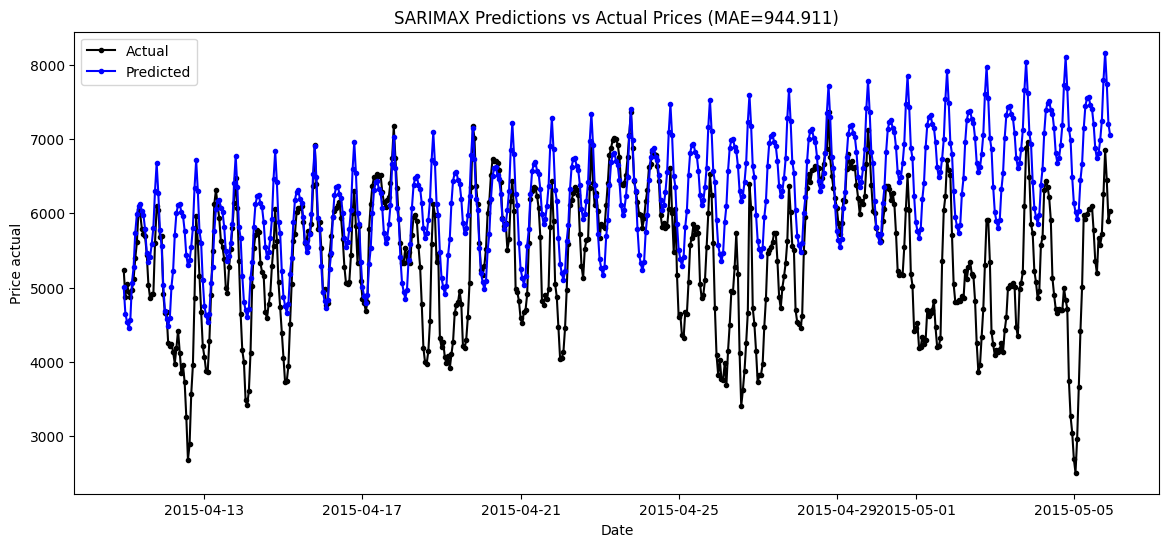

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

hist_size = 24

df_energy.index.freq = "h"
y_train = df_energy["price actual"].iloc[:train_cutoff]
y_test = df_energy["price actual"].iloc[train_cutoff:]

# Fit SARIMAX model
sarimax_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, hist_size))
sarimax_fit = sarimax_model.fit(disp=False)

# Forecast
y_pred = sarimax_fit.forecast(steps=len(y_test))

# Inverse transform the predictions and actual values
y_pred_actual = scaler_y.inverse_transform(y_pred.values.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_pred_actual, y_test_inv)

# Plot the results
fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(
    df_energy["price actual"].iloc[train_cutoff:].index,
    y_test_inv,
    "k.-",
    label="Actual",
)
axes.plot(
    df_energy["price actual"].iloc[train_cutoff:].index,
    y_pred_actual,
    "b.-",
    label="Predicted",
)
axes.set(xlabel="Date", ylabel="Price actual")
axes.set_title(f"SARIMAX Predictions vs Actual Prices (MAE={mae:.3f})")
axes.legend()
plt.show()

### XGBOOST forecast

- Multivariate
- Supervised learning problem
- Can be extended with more feature engineering


Text(0.5, 1.0, 'XGBoost Predictions vs Actual Prices (MAE=6.367)')

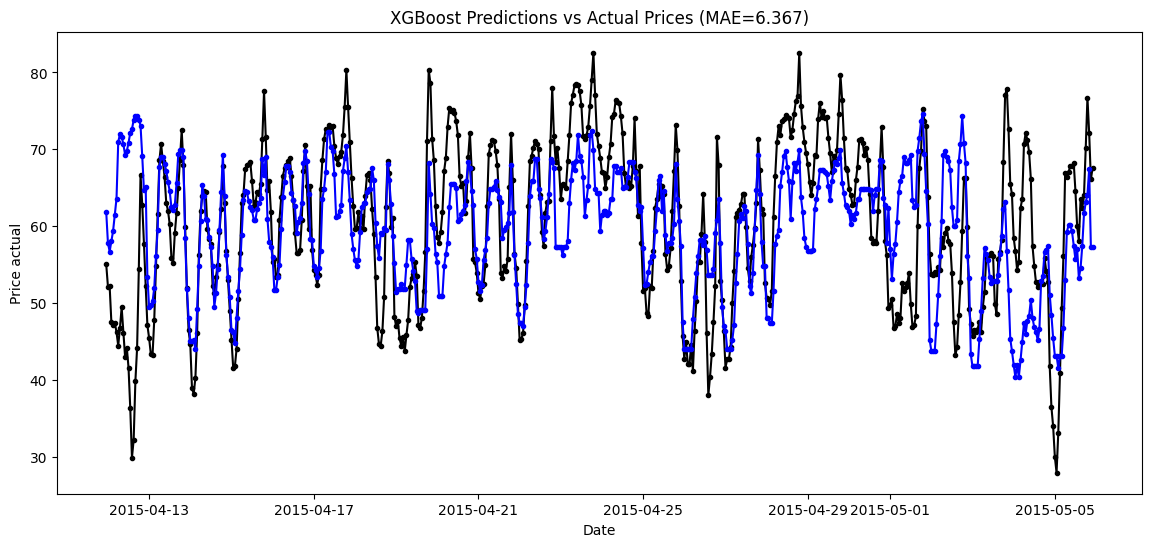

In [53]:
# number of hours to look back
hist_size = 24

X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test(
    hist_size=hist_size
)


def reshaping(X):
    reshaped_x = X.reshape(-1, X.shape[1] * X.shape[2])

    # Create column names like 'feature_timestep1', 'feature_timestep2', ...
    feature_names = df_energy.drop(columns=["price actual"]).columns
    columns = [
        f"{feature}_timestep{t+1}"
        for t in range(hist_size)
        for feature in feature_names
    ]

    return pd.DataFrame(reshaped_x, columns=columns)


X_train_xgb = reshaping(X_train)
X_test_xgb = reshaping(X_test)

# Grid of parameters to choose from
xgb_params = {
    "n_estimators": [10, 50, 100],
    "subsample": [0.6, 0.8, 1],
    "learning_rate": [0.01, 0.1, 0.5, 1],
    "gamma": [0.01, 0.1, 1, 5],
    "alpha": [0, 0.1, 0.5],
}


xgb_model = xgb.XGBRegressor()


# Uncomment the following lines to perform grid search
# ---------------------------------------------------
# grid_xgb = GridSearchCV(
#     xgb_model,
#     xgb_params,
#     cv=3,
#     n_jobs=-1,
#     verbose=10,
# )


# grid_xgb.fit(X_train_xgb, y_train)
# xgb_best_model = grid_xgb.best_estimator_

# print("Best parameters found: ", grid_xgb.best_params_)

# y_pred = xgb_best_model.predict(X_test_xgb)

# mae = mean_absolute_error(y_pred, y_test)
# print(f"Mean Absolute Error: {round(mae,3)}")
# ---------------------------------------------------

# Fit the model
xgb_model = xgb.XGBRegressor(
    **{
        "alpha": 0.1,
        "gamma": 1,
        "learning_rate": 0.1,
        "n_estimators": 50,
        "subsample": 0.8,
    }
)
xgb_model.fit(
    X_train_xgb,
    y_train,
    eval_set=[(X_train_xgb, y_train)],
    verbose=False,
)

y_pred = xgb_model.predict(X_test_xgb)
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)
mae = mean_absolute_error(y_pred_actual, y_test_inv)


fig, axes = plt.subplots(figsize=(14, 6))
axes.plot(
    df_energy["price actual"].iloc[train_cutoff + hist_size :].index,
    y_test_inv,
    "k.-",
    label="Actual",
)
axes.plot(
    df_energy["price actual"].iloc[train_cutoff + hist_size :].index,
    y_pred_actual,
    "b.-",
    label="Predicted",
)
axes.set(xlabel="Date", ylabel="Price actual")
axes.set_title(f"XGBoost Predictions vs Actual Prices (MAE={mae:.3f})")

### XGBoost global + local explanation with SHAP


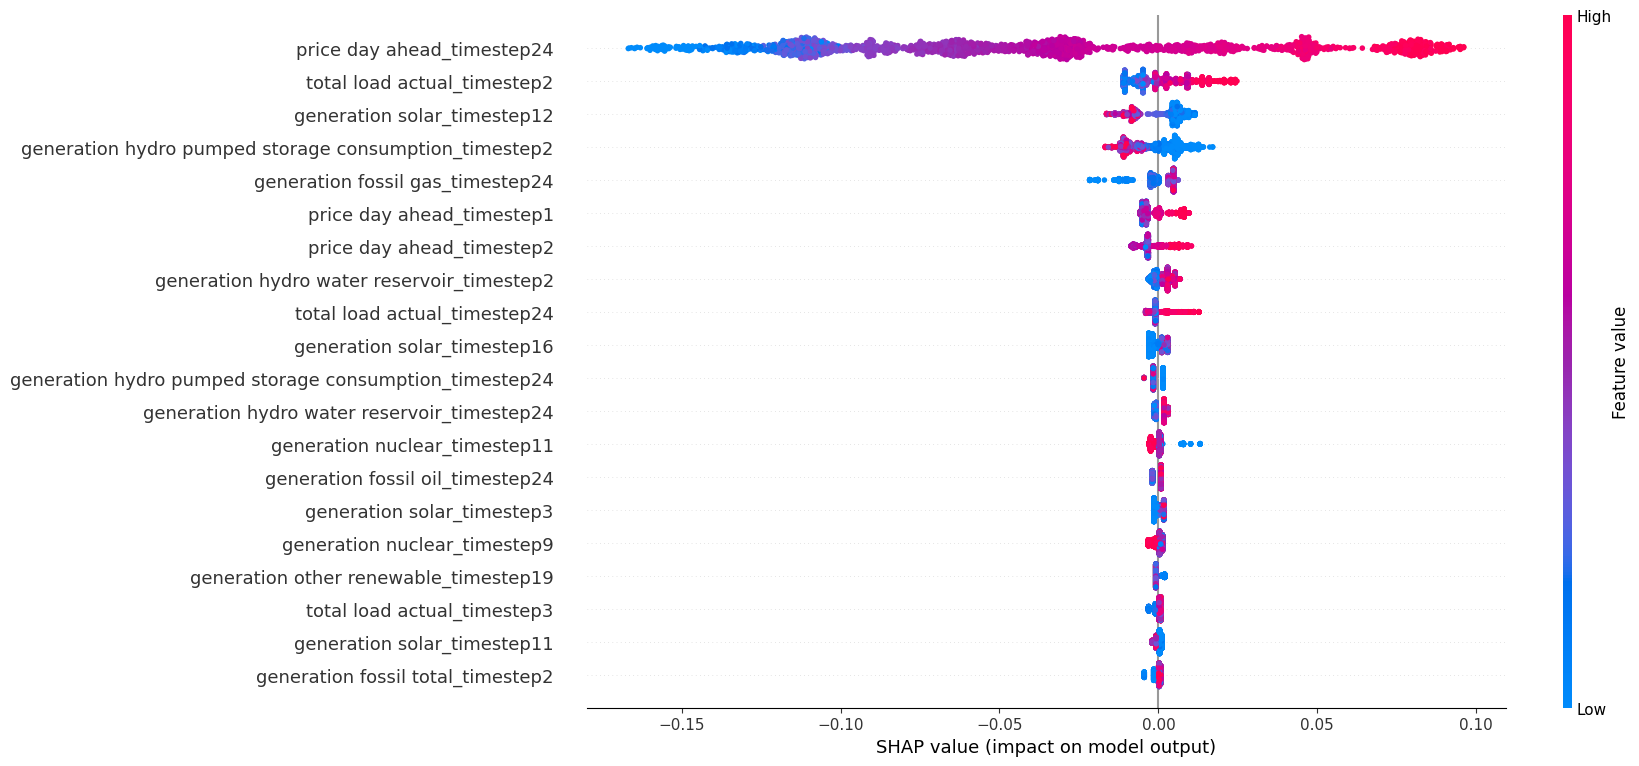

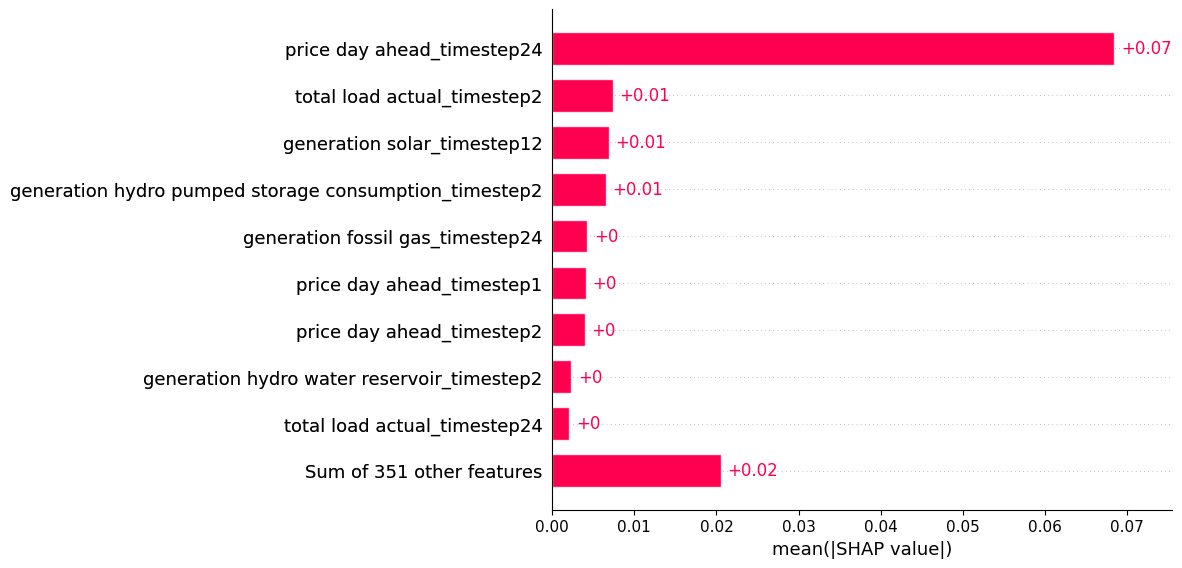

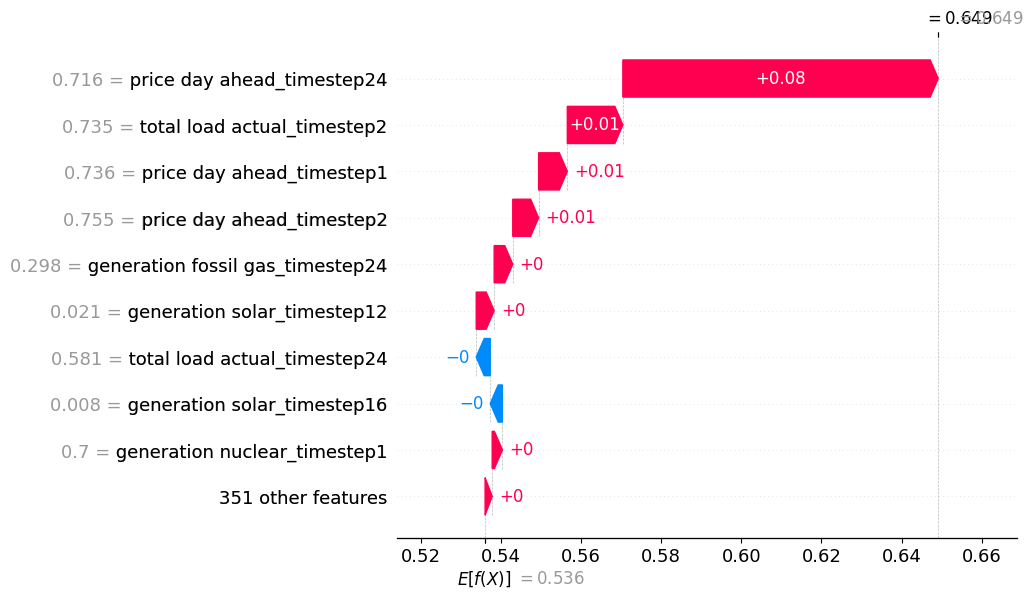

In [39]:
# SHAP expplantions
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_xgb)

# Summary plot: global feature importance
shap.summary_plot(shap_values, X_test_xgb, show=False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(5 * h, 0.8 * h)
plt.show()

# Bar plot: mean absolute SHAP values
shap.plots.bar(shap_values)

# Waterfall plot: local feature importance for the first prediction
shap.waterfall_plot(shap_values[0])

### XGBoost local explanation with LIME


In [42]:
from IPython.display import display, HTML
import lime
import lime.lime_tabular

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_xgb),
    feature_names=X_train_xgb.columns.tolist(),
    mode="regression",
)

# Select a few samples from the test set for explanation
samples_to_explain = X_test_xgb.iloc[:1, :]

# Generate and display LIME explanations
for i, (index, sample) in enumerate(samples_to_explain.iterrows()):
    explanation = lime_explainer.explain_instance(
        data_row=sample.values,
        predict_fn=xgb_model.predict,
        num_features=len(X_train_xgb.columns),
    )
    display(HTML(explanation.as_html()))

### LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1109
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0082
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079
Epoch 13/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081
Epoch 14/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071
Epoch 15/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068
Epoch 16/50
75/75 ━

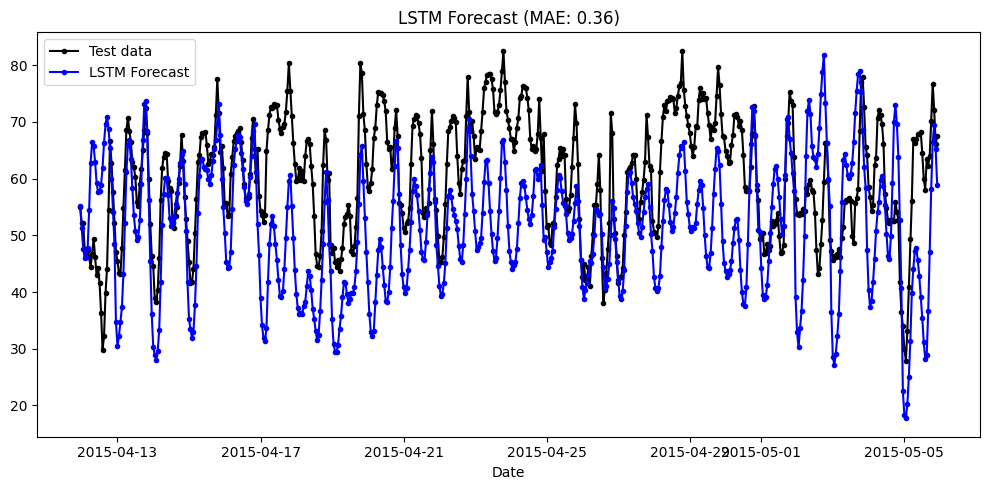

In [54]:
hist_size = 24

X_train, y_train, X_test, y_test, train_cutoff, scaler_y, scaler_X = get_train_test(
    hist_size=hist_size
)


n_features = X_train.shape[2]  # Number of features in the input


# Build LSTM model
model = Sequential()
model.add(Input(shape=(hist_size, n_features)))
model.add(LSTM(50, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()


# fit the model
model.fit(X_train, y_train, epochs=50)


y_pred = model.predict(X_test)


# Plot results
fig, ax = plt.subplots(figsize=(10, 5))


ax.plot(
    df_energy.iloc[train_cutoff + hist_size :].index,
    scaler_y.inverse_transform(y_test),
    "k.-",
    label="Test data",
)
ax.plot(
    df_energy.iloc[train_cutoff + hist_size :].index,
    scaler_y.inverse_transform(y_pred),
    "b.-",
    label="LSTM Forecast",
)
ax.set_title(f"LSTM Forecast (MAE: {np.sqrt(mean_absolute_error(y_test, y_pred)):.2f})")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

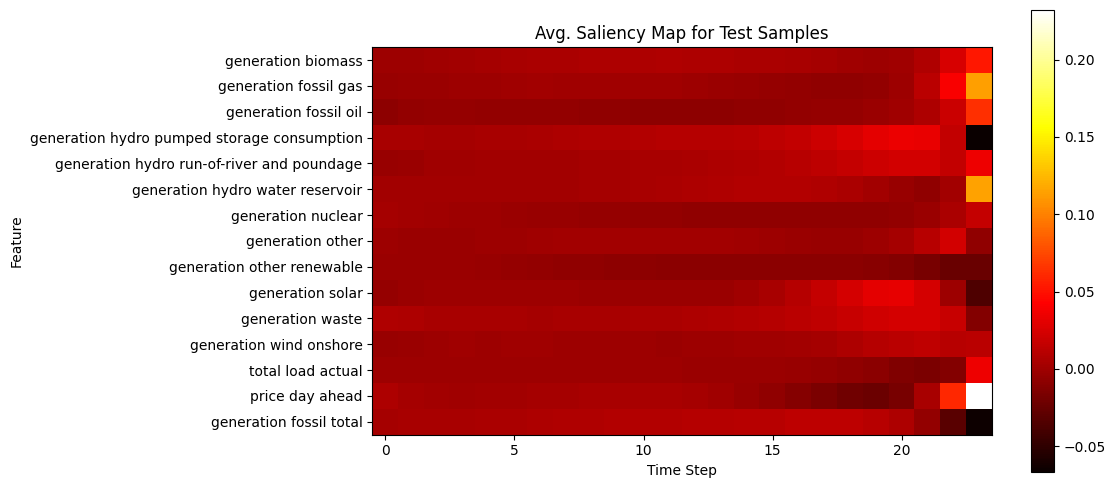

In [55]:
# %% based on gradients, calculate how much each feature contributes to the prediction

import tensorflow as tf
import matplotlib.pyplot as plt


# X_test is your test input of shape (samples, timesteps, features)
# model is your trained LSTM model
def compute_saliency_maps(model, X):
    """
    Compute saliency map for each sample in X
    """
    X_var = tf.Variable(X, dtype=float)
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        predictions = model(X_var)
    gradients = tape.gradient(predictions, X_var)
    return gradients.numpy()


# Compute saliency maps
saliency_maps = compute_saliency_maps(model, X_test)

# Plot saliency map for the first test sample
feature_names = df_energy.drop(columns=["price actual"]).columns
plt.figure(figsize=(10, 6))
plt.title("Avg. Saliency Map for Test Samples")
plt.xlabel("Time Step")
plt.ylabel("Feature")
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.imshow(np.mean(saliency_maps, axis=0).T, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.show()

In [52]:
from ShapTime import ShapleyValues, TimeImportance, TimeHeatmap


Tn = 10  # number of time steps
shap_values = ShapleyValues(model, X_train, Tn)
time_columns = [f"Time Step {i+1}" for i in range(Tn)]
shap_values = np.array(shap_values)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━

c:\Users\TWAARD\OneDrive - Capgemini\dev\ai-friday\challenge\ShapTime.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


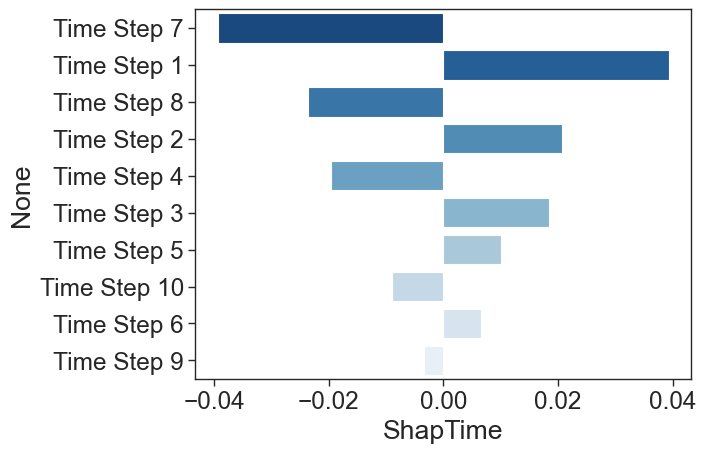

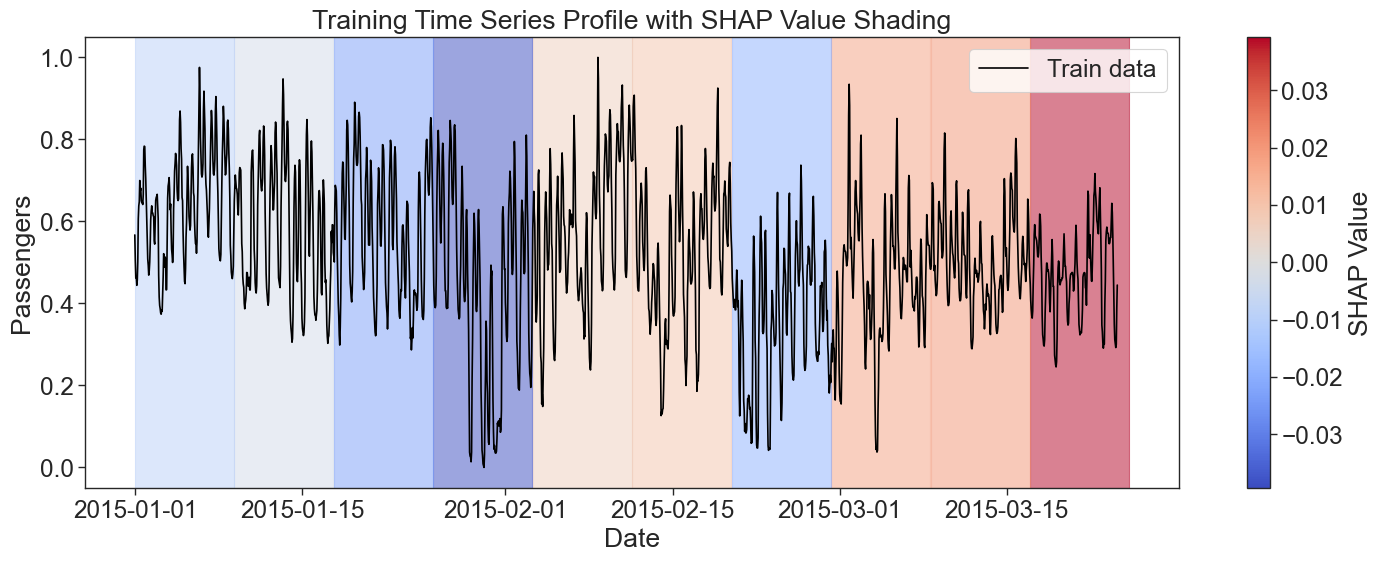

In [59]:
TimeImportance(Tn, shap_values, time_columns)
# ax = TimeHeatmap(Tn, shap_values, time_columns)


# Normalize SHAP values for color mapping
norm = plt.Normalize(shap_values.min(), shap_values.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(
    df_energy[: train_cutoff - hist_size].index, y_train, label="Train data", c="black"
)

# Shade time steps, adjusting x-axis spans to reflect 1/10th of the total timeframe
total_timeframe = len(df_energy[:train_cutoff].index)
time_step_span = total_timeframe // len(shap_values)

for i in range(len(shap_values)):
    start_idx = (len(shap_values) - 1 - i) * time_step_span
    end_idx = (len(shap_values) - i) * time_step_span
    ax.axvspan(
        df_energy[:train_cutoff].index[start_idx],
        df_energy[:train_cutoff].index[end_idx - 1],
        color=sm.to_rgba(shap_values[i]),
        alpha=0.5,
    )

ax.set_title("Training Time Series Profile with SHAP Value Shading")
ax.set_xlabel("Date")
ax.set_ylabel("Passengers")
ax.legend()
plt.colorbar(sm, ax=ax, label="SHAP Value")
plt.tight_layout()
plt.show()